** Skeleton of Assignment 4:**
    test if the distribution of 
    
    1) trip duration of bikers that ride during the day vs night
    
    2) age of bikers for trips originating in Manhattan and in Brooklyn
    
    are different. Use 3 tests: KS, Pearson's, Spearman's. 
    
    Use the scipy.stats functions scipy.stats.ks_2samp, scipy.stats.pearsonr, scipy.stats.spearmanr. 
    
    For the KS do the test with the entire dataset and with a subset 200 times smaller
    
    Choose a single significant threshold for the whole exercise. 
    
    For each test phrase the Null Hypothesis in words.
    
    Describe the return of the scipy function you use in each case.
    
    State the result in terms of rejection of the Null.

In [49]:
# my usual imports and setups
from __future__ import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
#imports downloader
from getCitiBikeCSV import getCitiBikeCSV # must have this function locally or in path
from get_jsonparsed_data import get_jsonparsed_data # must have this function locally or in path
%pylab inline

import scipy.stats
import os
#this makes my plots pretty! but it is totally not mandatory to do it
import json
s = json.load( open(os.getenv ('PUI2016')+"/fbb_matplotlibrc.json") )
pl.rcParams.update(s)

#set this to true while deeloping to subsample data
DEVELOPING = False

#chose day hours vs night hours:
DAYTIME = (6, 18)

Populating the interactive namespace from numpy and matplotlib


** Statistical significance threshold throughout: $\alpha = 0.05$ **

In [2]:
alpha = 0.05

# Read in data
I am reading in data from January and June 2015 with the function that I created getCitiBikeCSV. You are requested to use 2 months at least. It would be a good idea to use data from a colder and a warmer months, since there are more riders in the warm weather and ridership patterns may change with weather, temperature, etc. You should use data from multiple months, joining multiple datasets (thus addressing some systematic errors as well)

In [40]:
# download data: a dataset from January 
datestring01 = '201501'
getCitiBikeCSV(datestring01)
datestring06 = '201506'
getCitiBikeCSV(datestring06)

('Downloading', '201501')
file in place, you can continue
('Downloading', '201506')
file in place, you can continue


In [5]:
# read in data Jan
cb201501 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring01 + '-citibike-tripdata.csv')
cb201501.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1


In [6]:
#read in data Jun
cb201506 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring06 + '-citibike-tripdata.csv')
cb201506.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1338,6/1/2015 0:00,6/1/2015 0:22,128,MacDougal St & Prince St,40.727103,-74.002971,2021,W 45 St & 8 Ave,40.759291,-73.988597,20721,Subscriber,1984.0,1
1,290,6/1/2015 0:00,6/1/2015 0:05,438,St Marks Pl & 1 Ave,40.727791,-73.985649,312,Allen St & E Houston St,40.722055,-73.989111,21606,Subscriber,1997.0,1
2,634,6/1/2015 0:01,6/1/2015 0:11,383,Greenwich Ave & Charles St,40.735238,-74.000271,388,W 26 St & 10 Ave,40.749718,-74.002950,16595,Subscriber,1993.0,1
3,159,6/1/2015 0:01,6/1/2015 0:04,361,Allen St & Hester St,40.716059,-73.991908,531,Forsyth St & Broome St,40.718939,-73.992663,16949,Subscriber,1981.0,1
4,1233,6/1/2015 0:02,6/1/2015 0:22,382,University Pl & E 14 St,40.734927,-73.992005,532,S 5 Pl & S 4 St,40.710451,-73.960876,17028,Customer,NaN,0


In [107]:
#subsample data while developing code 
#THIS IS IMPORTANT! the computing speed when using the full sample is orohibitively slow
#for a good workflow it was necessary to develope on a subsample, then run the whole notebook on the full dataset

if DEVELOPING:
    cb2015 = cb201501[::1000]
else:
    cb2015 = pd.concat([cb201501, cb201506])

In [8]:
print ("Shape of CB DF")
cb2015.shape

Shape of CB DF


(1226771, 15)

In [9]:
cb2015['date'] = pd.to_datetime(cb2015.starttime)
# note that with dataframes I can refer to variables as dictionary keys, 
# i.e. df['starttime'] or as attributes: df.starttime. 
cb2015.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender
count,1.226771e+06,1.226771e+06,1.226771e+06,1.226771e+06,1.226771e+06,1.226771e+06,1.226771e+06,1.226771e+06,1.090751e+06,1.226771e+06
mean,8.463465e+02,4.561577e+02,4.073500e+01,-7.399105e+01,4.540858e+02,4.073470e+01,-7.399120e+01,1.816818e+04,1.975921e+03,1.084841e+00
std,3.052017e+03,3.730900e+02,1.923260e-02,1.226162e-02,3.707375e+02,1.919737e-02,1.228086e-02,2.102264e+03,1.150760e+01,5.481352e-01
min,6.000000e+01,7.200000e+01,4.068034e+01,-7.401713e+01,7.200000e+01,4.068034e+01,-7.401713e+01,1.452900e+04,1.885000e+03,0.000000e+00
25%,3.810000e+02,3.070000e+02,4.072182e+01,-7.400004e+01,3.060000e+02,4.072165e+01,-7.400026e+01,1.636700e+04,1.968000e+03,1.000000e+00
50%,6.050000e+02,4.170000e+02,4.073653e+01,-7.399076e+01,4.120000e+02,4.073650e+01,-7.399093e+01,1.815600e+04,1.978000e+03,1.000000e+00
75%,9.920000e+02,4.920000e+02,4.075020e+01,-7.398195e+01,4.910000e+02,4.074972e+01,-7.398195e+01,1.993100e+04,1.985000e+03,1.000000e+00
max,1.691873e+06,3.002000e+03,4.077152e+01,-7.395005e+01,3.002000e+03,4.077152e+01,-7.395005e+01,2.236400e+04,1.999000e+03,2.000000e+00


In [10]:
cb2015.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender', u'date'],
      dtype='object')

## SPLIT BY CATEGORY

splitting data by day vs night and looking at trip duration:

**H0: there is no statistical difference in the trip duration distribution during the day and the night**
$$ \alpha = 0.05 $$

extracting the age happens in the cell below

In [11]:
#extract hour when trip started
cb2015['starthour'] = pd.to_numeric(cb2015.starttime.apply(lambda x: 
                                                           x.split()[1].split(':')[0]))

In [12]:
#check start hour
cb2015.starthour.values[0]

0

In [13]:
# split day and night smaples
# chose trip starting between 6 and 18 as day trips
cb2015['dayride'] = (cb2015.starthour.values > DAYTIME[0]) & (cb2015.starthour.values < DAYTIME[1])

In [14]:
#collecting latitude and longitude for later splitting borroughs
latlon = (cb2015[['start station latitude', 
                'start station longitude']].values.astype(float))
print("The number of rows in the 2015 citibike dataset is", len(latlon))
#dropping not needed columns to lighten memory load
cb2015 = cb2015.drop(cb2015.columns[5:-1], axis=1).drop(cb2015.columns[1:3], axis=1)
cb2015.head()

('The number of rows in the 2015 citibike dataset is', 1226771)


,tripduration,start station id,start station name,dayride
0,1346,455,1 Ave & E 44 St,False
1,363,434,9 Ave & W 18 St,False
2,346,491,E 24 St & Park Ave S,False
3,182,384,Fulton St & Waverly Ave,False
4,969,474,5 Ave & E 29 St,False


In [15]:
#your df should look something like this
# look at these data carefully... you may see someinteresting values!
cb2015.describe()

,tripduration,start station id
count,1.226771e+06,1.226771e+06
mean,8.463465e+02,4.561577e+02
std,3.052017e+03,3.730900e+02
min,6.000000e+01,7.200000e+01
25%,3.810000e+02,3.070000e+02
50%,6.050000e+02,4.170000e+02
75%,9.920000e+02,4.920000e+02
max,1.691873e+06,3.002000e+03


# exploratory analysis

In [41]:
print ("Number of daytime rides", cb2015.dayride.sum())
print ("Number of nighttime rides", (~cb2015.dayride).sum())

Number of daytime rides 819517
Number of nighttime rides 407254


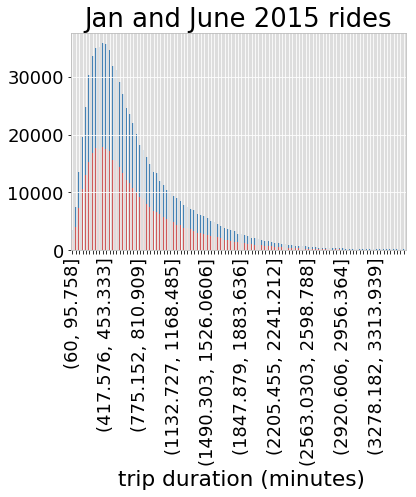

In [95]:
# plot daytime trip duration histogram in 100 bins
# plot 0% to 95% percentile because I expect these distribution to be long tailed and I see 43,000 hour trips above
pc = np.percentile(cb2015.tripduration, [0, 99])
bins = np.linspace(int(pc[0]), int(pc[1] / 100) * 100, 100)
dayax = cb2015[cb2015.dayride].tripduration.groupby(
    pd.cut(cb2015[cb2015.dayride].tripduration, bins)).\
                    agg([count_nonzero]).plot(kind='bar', legend=False)
dayax.set_title("Jan and June 2015 rides")
# plot nighttime trip duration histogram
cb2015[~cb2015.dayride].tripduration.groupby(
    pd.cut(cb2015[~cb2015.dayride].tripduration, bins)).\
                    agg([count_nonzero]).plot(kind='bar', legend=False, ax=dayax, 
                                             color='IndianRed')
xlab = dayax.get_xticklabels()
dayax.set_xticklabels(['' if float(i)%10 > 0 else xlab[i] for i in range(len(xlab))]);
dayax.set_xlabel(" trip duration (minutes)");



In [77]:
print ("Figure 1: histogrammed distribution of ride duration by day (blue) and night (red).\n" +
       "The distributions are plotted up to the 95th percentile (removing outliers in the tail).\n" +
       "The distributions look similar, such that visual inspection is not sufficient " +
       "to determine if there is a difference." + 
       "The number of rides is obviously higher during day hours.\n" +
       "Note, that our definition of day includes %d hours between hour %d and %d"%(DAYTIME[1] - DAYTIME[0],
                                                                                    DAYTIME[0], DAYTIME[1]))

Figure 1: histogrammed distribution of ride duration by day (blue) and night (red).
The distributions are plotted up to the 95th percentile (removing outliers in the tail).
The distributions look similar, such that visual inspection is not sufficient to determine if there is a difference.The number of rides is obviously higher during day hours.
Note, that our definition of day includes 12 hours between hour 6 and 18


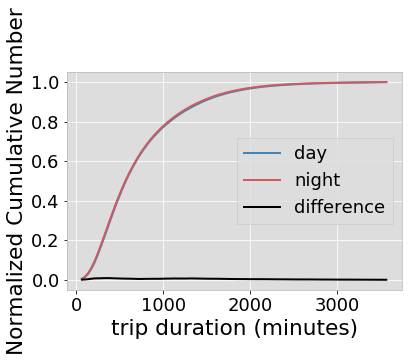

In [106]:
#print df.ageS, df.ageS.cumsum()

csD = cb2015[cb2015.dayride].tripduration.groupby(pd.cut(cb2015[cb2015.dayride].tripduration, 
                                                 bins)).agg([count_nonzero]).cumsum()

csN = cb2015[~cb2015.dayride].tripduration.groupby(pd.cut(cb2015[~cb2015.dayride].tripduration, 
                                                  bins)).agg([count_nonzero]).cumsum()

#print (np.abs(csD / csD.max()-csN / csN.max()))

pl.plot(bins[:-1] + 5, csD / csD.max(), label = "day")
pl.plot(bins[:-1] + 5, csN / csN.max(), label = "night")
pl.plot(bins[:-1] + 5, np.abs(csN / csN.max() - csD / csD.max()), 'k-',
        label = "difference")
pl.xlabel("trip duration (minutes)")
pl.ylabel("Normalized Cumulative Number")
pl.legend();

** Figure 2: the cumulative distribution of CitiBike riders' ages by day vs night trips.** 

The cumulative distribution is, by eye, practically identical with the maximum difference in heights between the cumulative distributions reached near 100 minutes of travel time. The difference is much less than 10%.

# KS tests to compare 2 samples

http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.ks_2samp.html

Null: the two distribution come from the same parent distribution

In [43]:
ks = scipy.stats.ks_2samp(cb2015[cb2015.dayride].tripduration, cb2015[~cb2015.dayride].tripduration)
print (ks)
if ks[1] >= alpha: 
    print ("The Null hypothesis that the two samples are generated " + 
            "by the same parent distribution cannot be rejected (p>=0.05)")
else: 
    print ("The Null hypothesis that the two samples are generated " + 
            "by the same parent distribution is rejected (p<0.05)")
    

Ks_2sampResult(statistic=0.010931405251323301, pvalue=1.1233645097381771e-28)
The Null hypothesis that the two samples are generated by the same parent distribution is rejected (p<0.05)


** Note on the KS test: the KS test, and generally any test of Null Hypothesis Statistical Testing, has higher power for larger samples. With a million observations, 100s of thousands in each sample tiny differences tend to become statistically significant. ** (The distribution looked different by eye in a cumulative plot in the testig phase, with 1000 fewer samples but the p-value was less significant)

** Now retest using a test for correlation. **

The null hypothesis is that the two samples are generated from the same distribution. 

The alternative hypothesis is that the two samples are generated by unrelated distributions.

Note that this is not a rigorous test, unlike the KS test, and according to scipy.stats.pearsonr _"The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so."_


In [30]:
#more rides during the day than during the night: subsample day rides
dfday = cb2015[cb2015.dayride].iloc[np.random.choice(range(len(cb2015[cb2015.dayride])), (~cb2015.dayride).sum(), 
                                      replace=False)]

In [44]:
parsons = scipy.stats.pearsonr(np.sort(dfday.tripduration), np.sort(cb2015[~cb2015.dayride].tripduration))
print ("Parson's test result", parsons)
if parsons[1] >= alpha: 
    print (r"The Null hypothesis that the two samples are generated from uncorrelated distributions. " + 
           "cannot be rejected (p>=0.05)")
else: 
    print ("The Null hypothesis that the two samples are generated from uncorrelated distributions. " + 
           "is rejected (p = %.3f<0.05)"%parsons[1])
 

Parson's test result (0.97058478943780102, 0.0)
The Null hypothesis that the two samples are generated from uncorrelated distributions. is rejected (p = 0.000<0.05)


# Spearman's  test for correlation

http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html#scipy.stats.spearmanr

In [45]:
spearmanr = scipy.stats.spearmanr(np.sort(dfday.tripduration), np.sort(cb2015[~cb2015.dayride].tripduration))
print ("Spearman's r test result", spearmanr)
if spearmanr[1] >= alpha: 
    print ("The Null hypothesis that the two samples are generated from uncorrelated distributions. " + 
           "cannot be rejected (p>=0.05)")
else: 
    print ("The Null hypothesis that the two samples are generated from uncorrelated distributions. " + 
           "is rejected (p = %.3f<0.05)"%spearmanr[1])
 

Spearman's r test result SpearmanrResult(correlation=0.99999919564105111, pvalue=0.0)
The Null hypothesis that the two samples are generated from uncorrelated distributions. is rejected (p = 0.000<0.05)


** This test is often used to assess if sample are generated by the same distribution but in fact it tests if the samples are generated by _correlated_ distributions. As a test to assess independence it is not powerful, as even a small amount of correlation would raise the p-value**

## BK vs Manhattan
reverse geocoding will give me the coordinates of each station will give me its location:
**NOTE: I do not need to run the query for every ride, but only for every station! **

In [59]:
nstations = pd.DataFrame(latlon).drop_duplicates().shape[0]
print ("number of stations: ", nstations)

number of stations:  335


In [55]:
latlon[:,0]

array([ 40.75001986,  40.74317449,  40.74096374, ...,  40.75455731,
        40.72066442,  40.71307916])

In [74]:
#this cells reverse geocodes coordinates to zip codes
#my API is saved as an environmental variable
county = np.array([''] * len(cb2015))

for i,ll in enumerate(pd.DataFrame(latlon).drop_duplicates().values):
    print ("%d/%d"%(i, nstations))
    url = ("https://maps.googleapis.com/maps/api/geocode/json?latlng=" +
           "%f,%f&key=%s"%(
            ll[0], ll[1], os.getenv('GOOGLEAPI')))
    #print ("https://maps.googleapis.com/maps/api/geocode/json?latlng=" +
    #       "%f,%f&key=%s"%(
    #        ll[0], ll[1], os.getenv('GOOGLEAPI')))
    #print (get_jsonparsed_data(url)["results"][0]['address_components'][4])
    # for testing break loop after N
    #if i>10: break
    revgeo = get_jsonparsed_data(url)["results"][0]['address_components'][4]
    #print (revgeo)
    county[(latlon[:,0] == ll[0]) * 
           (latlon[:,1] == ll[1])] = revgeo['long_name']
cb2015['county'] = county
cb2015.head()

0/335
1/335
2/335
3/335
4/335
5/335
6/335
7/335
8/335
9/335
10/335
11/335
12/335
13/335
14/335
15/335
16/335
17/335
18/335
19/335
20/335
21/335
22/335
23/335
24/335
25/335
26/335
27/335
28/335
29/335
30/335
31/335
32/335
33/335
34/335
35/335
36/335
37/335
38/335
39/335
40/335
41/335
42/335
43/335
44/335
45/335
46/335
47/335
48/335
49/335
50/335
51/335
52/335
53/335
54/335
55/335
56/335
57/335
58/335
59/335
60/335
61/335
62/335
63/335
64/335
65/335
66/335
67/335
68/335
69/335
70/335
71/335
72/335
73/335
74/335
75/335
76/335
77/335
78/335
79/335
80/335
81/335
82/335
83/335
84/335
85/335
86/335
87/335
88/335
89/335
90/335
91/335
92/335
93/335
94/335
95/335
96/335
97/335
98/335
99/335
100/335
101/335
102/335
103/335
104/335
105/335
106/335
107/335
108/335
109/335
110/335
111/335
112/335
113/335
114/335
115/335
116/335
117/335
118/335
119/335
120/335
121/335
122/335
123/335
124/335
125/335
126/335
127/335
128/335
129/335
130/335
131/335
132/335
133/335
134/335
135/335
136/335
137/335
138/33

,tripduration,start station id,start station name,dayride,zipcodes,county
0,1346,455,1 Ave & E 44 St,False,10017.0,NaN
1,363,434,9 Ave & W 18 St,False,10011.0,NaN
2,346,491,E 24 St & Park Ave S,False,10010.0,NaN
3,182,384,Fulton St & Waverly Ave,False,11238.0,NaN
4,969,474,5 Ave & E 29 St,False,10016.0,NaN


In [81]:
cb2015['county'] = county


In [84]:
cb2015.county.head()

0    N
1    N
2    N
3    K
4    N
Name: county, dtype: object

In [85]:
cb2015['BK'] = (cb2015.county.values == "K")
cb2015['M'] = (cb2015.county.values == "N")

In [92]:
print ("Number of daytime rides", cb2015.BK.sum())
print ("Number of nighttime rides", cb2015.M.sum())
print ("ratio of rides BK to Manhattan:", cb2015.BK.sum() * 1.0 / cb2015.M.sum())

Number of daytime rides 66267
Number of nighttime rides 1153432
ratio of rides BK to Manhattan: 0.0574520214456


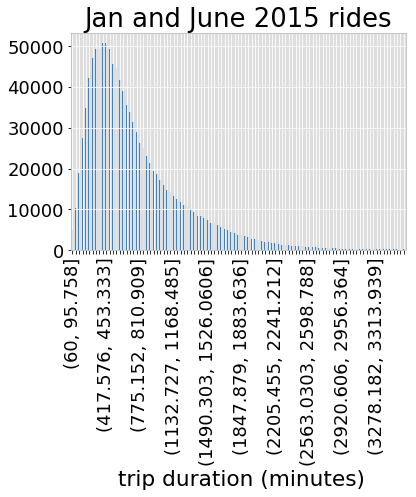

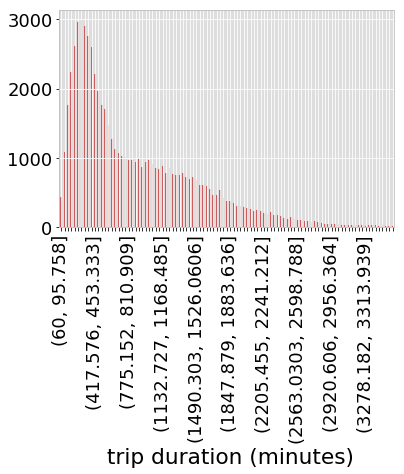

In [96]:
axM = cb2015[cb2015.M].tripduration.groupby(
    pd.cut(cb2015[cb2015.M].tripduration, bins)).\
                    agg([count_nonzero]).plot(kind='bar', legend=False)
axM.set_title("Jan and June 2015 rides")

# plot nighttime trip duration histogram
axBK = cb2015[cb2015.BK].tripduration.groupby(
    pd.cut(cb2015[cb2015.BK].tripduration, bins)).\
                    agg([count_nonzero]).plot(kind='bar', legend=False,#, ax=dayax, 
                                             color='IndianRed')
xlab = dayax.get_xticklabels()
axBK.set_xticklabels(['' if float(i)%10 > 0 else xlab[i] for i in range(len(xlab))]);
axM.set_xticklabels(['' if float(i)%10 > 0 else xlab[i] for i in range(len(xlab))]);

axM.set_xlabel(" trip duration (minutes)");
axBK.set_xlabel(" trip duration (minutes)");


** Figure 3: when splitting the sample by origin between Manhattan and Brooklyn the distribution of durations appear visibly different, with the BK distribution showing a flatter decline, and perhaps a second peak at ~1,000 minutes **. Also it should be note that now the number of rides is far more unbalanced between the two samples, with only about 5% of the rides originating from BK. 

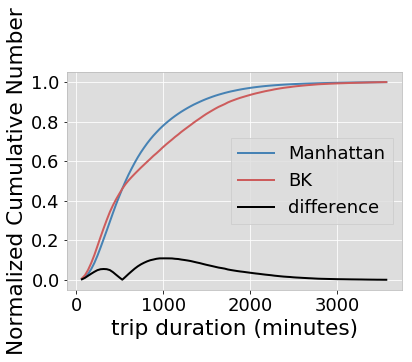

In [105]:
#print df.ageS, df.ageS.cumsum()

csM = cb2015[cb2015.M].tripduration.groupby(pd.cut(cb2015[cb2015.M].tripduration, 
                                                 bins)).agg([count_nonzero]).cumsum()

csBK = cb2015[cb2015.BK].tripduration.groupby(pd.cut(cb2015[cb2015.BK].tripduration, 
                                                  bins)).agg([count_nonzero]).cumsum()

#print (np.abs(csD / csD.max()-csN / csN.max()))

pl.plot(bins[:-1] + 5, csM / csM.max(), label = "Manhattan")
pl.plot(bins[:-1] + 5, csBK / csBK.max(), label = "BK")
pl.plot(bins[:-1] + 5, np.abs(csBK / csBK.max() - csM / csM.max()), 'k-',
        label = "difference")
pl.xlabel("trip duration (minutes)")
pl.ylabel("Normalized Cumulative Number")
pl.legend();

** Figure 4: the difference between the distribution of trip duration for trips originating in Manhattan (blue) vs Brooklyn (red) in cumulative space is indicated by the black line. The distance appears bimodal, indicating an obvious difference in the shape of the distribution, and it peaks near 1,000 minutes at over 10% **

In [97]:
ks = scipy.stats.ks_2samp(cb2015[cb2015.BK].tripduration, cb2015[cb2015.M].tripduration)
print (ks)
if ks[1] >= alpha: 
    print ("The Null hypothesis that the two samples are generated " + 
            "by the same parent distribution cannot be rejected (p>=0.05)")
else: 
    print ("The Null hypothesis that the two samples are generated " + 
            "by the same parent distribution is rejected (p<0.05)")
    

Ks_2sampResult(statistic=0.11289872747168939, pvalue=0.0)
The Null hypothesis that the two samples are generated by the same parent distribution is rejected (p<0.05)


In [101]:
manhattan = cb2015[cb2015.M].iloc[np.random.choice(range(len(cb2015[cb2015.M])), (cb2015.BK).sum(), 
                                      replace=False)]
parsons = scipy.stats.pearsonr(np.sort(manhattan.tripduration), np.sort(cb2015[cb2015.BK].tripduration))
print ("Parson's test result", parsons)
if parsons[1] >= alpha: 
    print (r"The Null hypothesis that the two samples are generated from uncorrelated distributions. " + 
           "cannot be rejected (p>=0.05)")
else: 
    print ("The Null hypothesis that the two samples are generated from uncorrelated distributions. " + 
           "is rejected (p = %.3f<0.05)"%parsons[1])
 

Parson's test result (0.90564048432517108, 0.0)
The Null hypothesis that the two samples are generated from uncorrelated distributions. is rejected (p = 0.000<0.05)


In [102]:
spearmanr = scipy.stats.spearmanr(np.sort(manhattan.tripduration), np.sort(cb2015[cb2015.BK].tripduration))
print ("Spearman's r test result", spearmanr)
if spearmanr[1] >= alpha: 
    print ("The Null hypothesis that the two samples are generated from uncorrelated distributions. " + 
           "cannot be rejected (p>=0.05)")
else: 
    print ("The Null hypothesis that the two samples are generated from uncorrelated distributions. " + 
           "is rejected (p = %.3f<0.05)"%spearmanr[1])
 

Spearman's r test result SpearmanrResult(correlation=0.9999993064254542, pvalue=0.0)
The Null hypothesis that the two samples are generated from uncorrelated distributions. is rejected (p = 0.000<0.05)


** The KS, Pearson's and Spearman's test conclude that the populations that generate the samples of rides from BK and Manhattan under consideration are different. Here we have a visual confirmation of this statistical difference, while earlier the statistical tests were reporting a result not obvious by visual inspection **

/Users/fbianco/science/Dropbox/UI/PUI2017_fb55/HW4_fb55
